In [1]:
from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate
import torch
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
%matplotlib inline

/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
def load_model(module=MetrixXYHistSurrogate, checkpoint_path: str="outputs/xy_hist/muqyzwbp/checkpoints/epoch=8739-step=106732880.ckpt"):
    model = module.load_from_checkpoint(checkpoint_path)
    model.to(torch.device('cpu'))
    model.compile()
    model.eval()
    return model

model = load_model()

Sequential(
  (0): Linear(in_features=34, out_features=34, bias=True)
  (1): Mish()
  (2): Linear(in_features=34, out_features=77, bias=True)
  (3): Mish()
  (4): Linear(in_features=77, out_features=87, bias=True)
  (5): Mish()
  (6): Linear(in_features=87, out_features=100, bias=True)
  (7): Sigmoid()
)


In [3]:
with torch.no_grad():
    out = model(torch.ones((1, 34))*0.5).reshape(2, -1)
    print(out.shape)

torch.Size([2, 50])


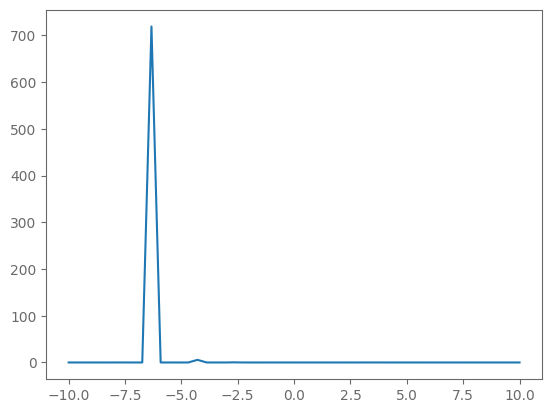

In [9]:

plt.plot(torch.linspace(-10, 10, 50), out[0]*22594.)
#plt.show()

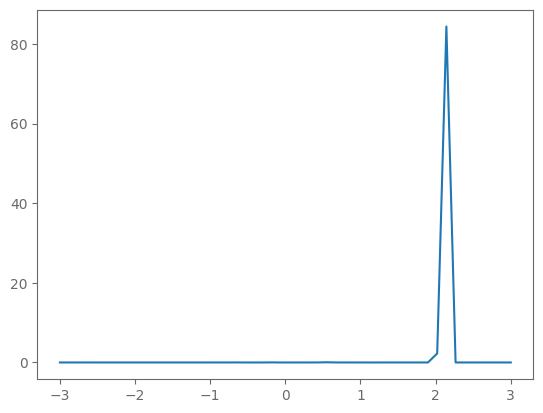

In [10]:
plt.plot(torch.linspace(-3, 3, 50), out[1]*22594.)

In [11]:
from ray_nn.data.transform import Select
from ray_nn.nn.xy_hist_data_models import StandardizeXYHist
from ray_tools.simulation.torch_datasets import BalancedMemoryDataset, MemoryDataset, RayDataset
import glob
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/50+50_data_raw_*.h5')) # ['datasets/metrix_simulation/ray_emergency_surrogate/49+50_data_raw_0.h5']

load_len = 1000

dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/histogram', '1e5/n_rays'], transform=Select(keys=['1e5/params', '1e5/histogram', '1e5/n_rays'], search_space=params(), non_dict_transform={'1e5/histogram': StandardizeXYHist()}))

memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)#, min_n_rays=500)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.84it/s]


12 torch.Size([34]) torch.Size([2, 50, 1])
tensor(5.1400)
tensor([0.9346, 0.0364, 0.0351, 0.8847, 0.5996, 0.0208, 0.7500, 0.0226, 0.6771,
        0.4640, 0.1809, 0.0213, 0.3900, 0.4234, 0.1920, 0.7920, 0.5679, 0.2175,
        0.1767, 0.3548, 0.1172, 0.7044, 0.6402, 0.6648, 0.5946, 0.9630, 0.4034,
        0.0215, 0.3933, 0.1175, 0.2736, 0.8222, 0.0265, 0.2303])


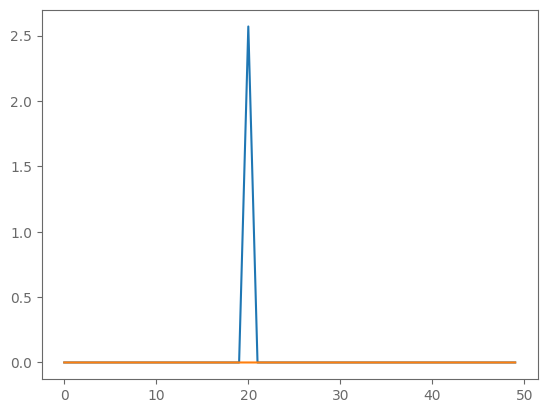

In [30]:
for i,z in enumerate(memory_dataset):
    x = z[0]
    y = z[1]
    with torch.no_grad():
        if y.sum() > 5:
            print(i, x.shape, y.shape)
            print(y.sum())
            out = model(x).reshape(2, -1)
            plt.plot(y[0].flatten())
            plt.plot(out[0].detach().cpu())
            print(x)
            break

In [7]:
len(memory_dataset)

1000

In [8]:
#for tu in memory_dataset:
#    x = tu[0]
#    y = tu[1]
    #print(x.shape)
    #print(y.shape)

In [10]:
with torch.no_grad():
    
    print(out.shape)


torch.Size([2, 50])


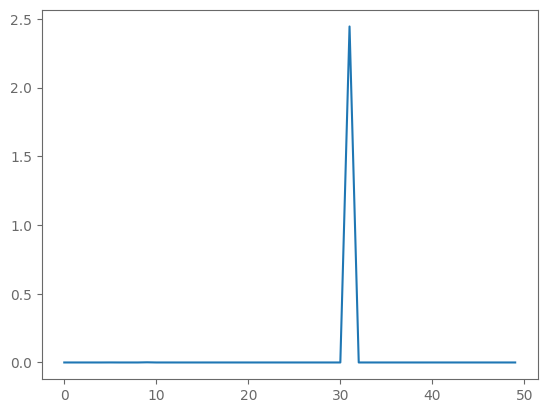

In [23]:
plt.plot(out[0]*22594*70)

In [4]:
from ray_nn.data.lightning_data_module import DefaultDataModule
from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate
import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor
import glob
from ray_nn.data.transform import Select
from ray_nn.nn.xy_hist_data_models import StandardizeXYHist
from ray_tools.simulation.torch_datasets import BalancedMemoryDataset, MemoryDataset, RayDataset
import glob
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from lightning.pytorch.loggers import WandbLogger

load_len: int | None = 1000
dataset_normalize_outputs = True
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/50+50_data_raw_*.h5')) # ['datasets/metrix_simulation/ray_emergency_surrogate/49+50_data_raw_0.h5']
dataset = RayDataset(h5_files=h5_files,
                    sub_groups=['1e5/params',
                                '1e5/histogram', '1e5/n_rays'], transform=Select(keys=['1e5/params', '1e5/histogram', '1e5/n_rays'], search_space=params(), non_dict_transform={'1e5/histogram': StandardizeXYHist()}))

memory_dataset = BalancedMemoryDataset(dataset=dataset, load_len=load_len, min_n_rays=500)
datamodule = DefaultDataModule(dataset=memory_dataset, num_workers=4)
datamodule.prepare_data()
model = MetrixXYHistSurrogate(dataset_length=load_len, dataset_normalize_outputs=dataset_normalize_outputs)
wandb_logger = WandbLogger(name="ref_bal_500_sch_.999_test", project="xy_hist", save_dir='outputs')
#wandb_logger = None
datamodule.setup(stage="test")

lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = L.Trainer(max_epochs=10000, logger=wandb_logger, log_every_n_steps=100, check_val_every_n_epoch=1, callbacks=[lr_monitor])
trainer.init_module()

trainer.test(datamodule=datamodule, ckpt_path='outputs/xy_hist/50f8si6i/checkpoints/epoch=29-step=5842830.ckpt', model=model)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.78it/s]


Sequential(
  (0): Linear(in_features=34, out_features=34, bias=True)
  (1): Mish()
  (2): Linear(in_features=34, out_features=77, bias=True)
  (3): Mish()
  (4): Linear(in_features=77, out_features=87, bias=True)
  (5): Mish()
  (6): Linear(in_features=87, out_features=100, bias=True)
  (7): Sigmoid()
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: hzbian. Use `wandb login --relogin` to force relogin


Restoring states from the checkpoint path at outputs/xy_hist/50f8si6i/checkpoints/epoch=29-step=5842830.ckpt
Loaded model weights from the checkpoint at outputs/xy_hist/50f8si6i/checkpoints/epoch=29-step=5842830.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │  0.00020004702673759311   │
│     val_nonempty_loss     │   0.0002511220227461308   │
└───────────────────────────┴───────────────────────────┘

[{'val_nonempty_loss': 0.0002511220227461308,
  'val_loss': 0.00020004702673759311}]

<Figure size 640x480 with 0 Axes>

In [5]:
test_dl = datamodule.test_dataloader()

tensor([[0.8463, 0.4988, 0.6306,  ..., 0.1856, 0.5794, 0.7808],
        [0.3252, 0.9398, 0.4139,  ..., 0.4391, 0.1458, 0.3781],
        [0.6326, 0.4516, 0.2560,  ..., 0.3393, 0.5869, 0.4206],
        ...,
        [0.0936, 0.9531, 0.6390,  ..., 0.9060, 0.8542, 0.5956],
        [0.8240, 0.6178, 0.8283,  ..., 0.5971, 0.5773, 0.7947],
        [0.9346, 0.0364, 0.0351,  ..., 0.8222, 0.0265, 0.2303]])


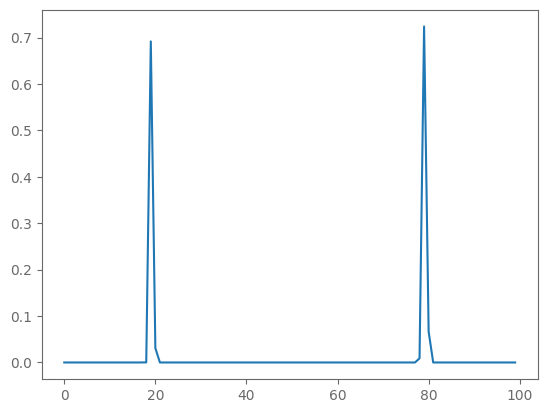

tensor([[0.6056, 0.3807, 0.1497,  ..., 0.5602, 0.3073, 0.7995],
        [0.2992, 0.8157, 0.9927,  ..., 0.5124, 0.0636, 0.2539],
        [0.8398, 0.5155, 0.6170,  ..., 0.0227, 0.0651, 0.6682],
        ...,
        [0.9156, 0.8135, 0.3116,  ..., 0.1478, 0.1002, 0.2331],
        [0.0634, 0.6024, 0.4232,  ..., 0.5324, 0.2642, 0.5179],
        [0.9521, 0.5949, 0.1098,  ..., 0.4616, 0.2087, 0.0887]])


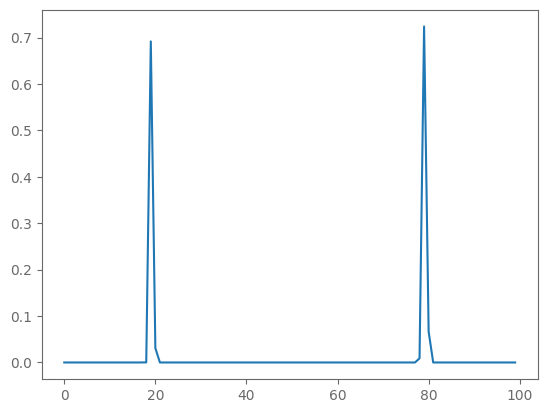

tensor([[0.2942, 0.2199, 0.3264,  ..., 0.1946, 0.1754, 0.5396],
        [0.0687, 0.5576, 0.1516,  ..., 0.2871, 0.2653, 0.1059],
        [0.2064, 0.8063, 0.9227,  ..., 0.3637, 0.9639, 0.8869],
        ...,
        [0.6417, 0.1113, 0.4726,  ..., 0.8904, 0.4657, 0.4595],
        [0.0687, 0.5576, 0.1516,  ..., 0.2871, 0.2653, 0.1059],
        [0.1507, 0.9042, 0.7505,  ..., 0.4055, 0.7996, 0.1433]])


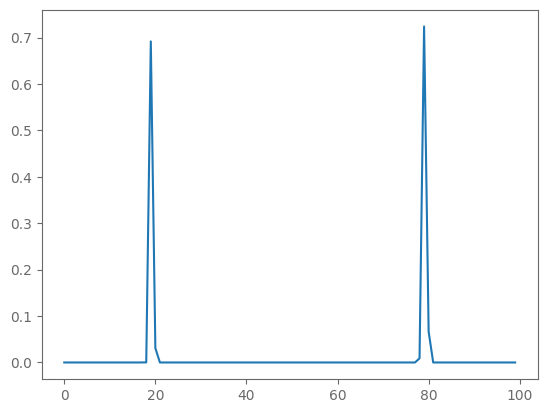

tensor([[0.4753, 0.1683, 0.2670,  ..., 0.8222, 0.1833, 0.4977],
        [0.0957, 0.9739, 0.4856,  ..., 0.1695, 0.1781, 0.7375],
        [0.9346, 0.0364, 0.0351,  ..., 0.8222, 0.0265, 0.2303],
        ...,
        [0.8952, 0.7547, 0.6697,  ..., 0.0579, 0.7950, 0.5644],
        [0.7471, 0.0469, 0.5326,  ..., 0.6940, 0.4824, 0.2279],
        [0.2464, 0.2643, 0.5143,  ..., 0.8598, 0.5134, 0.7537]])


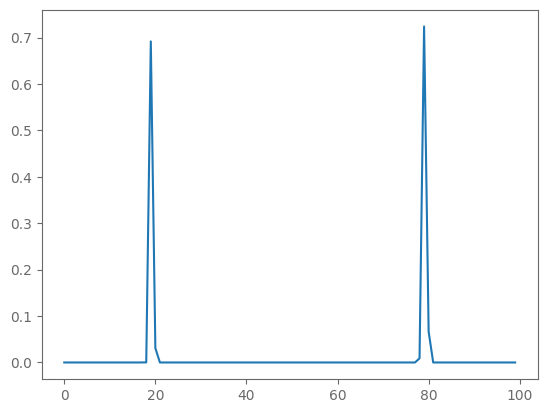

tensor([[0.4008, 0.3169, 0.0834,  ..., 0.1671, 0.9632, 0.2381],
        [0.6061, 0.7494, 0.9935,  ..., 0.8368, 0.5540, 0.6147],
        [0.2992, 0.8157, 0.9927,  ..., 0.5124, 0.0636, 0.2539],
        ...,
        [0.9873, 0.5452, 0.2764,  ..., 0.9243, 0.7379, 0.8946],
        [0.7849, 0.0545, 0.2106,  ..., 0.8360, 0.8521, 0.4019],
        [0.2942, 0.2199, 0.3264,  ..., 0.1946, 0.1754, 0.5396]])


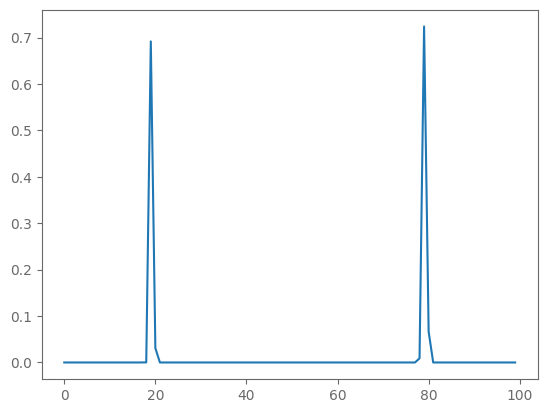

tensor([[0.5219, 0.5478, 0.6823,  ..., 0.2544, 0.8886, 0.6099],
        [0.1423, 0.7466, 0.0200,  ..., 0.1494, 0.1998, 0.6985],
        [0.2942, 0.2199, 0.3264,  ..., 0.1946, 0.1754, 0.5396],
        ...,
        [0.2949, 0.0516, 0.9876,  ..., 0.5931, 0.5790, 0.1837],
        [0.2949, 0.0516, 0.9876,  ..., 0.5931, 0.5790, 0.1837],
        [0.9346, 0.0364, 0.0351,  ..., 0.8222, 0.0265, 0.2303]])


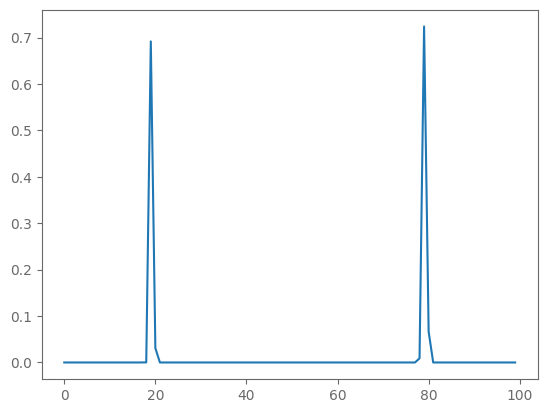

tensor([[0.8398, 0.5155, 0.6170,  ..., 0.0227, 0.0651, 0.6682],
        [0.9346, 0.0364, 0.0351,  ..., 0.8222, 0.0265, 0.2303],
        [0.2064, 0.8063, 0.9227,  ..., 0.3637, 0.9639, 0.8869],
        ...,
        [0.7471, 0.0469, 0.5326,  ..., 0.6940, 0.4824, 0.2279],
        [0.7471, 0.0469, 0.5326,  ..., 0.6940, 0.4824, 0.2279],
        [0.0687, 0.5576, 0.1516,  ..., 0.2871, 0.2653, 0.1059]])


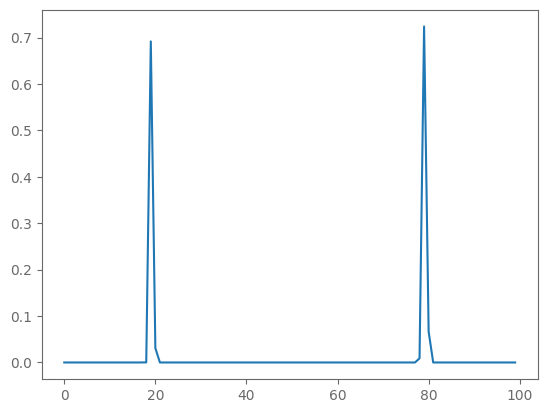

tensor([[0.0936, 0.9531, 0.6390,  ..., 0.9060, 0.8542, 0.5956],
        [0.3252, 0.9398, 0.4139,  ..., 0.4391, 0.1458, 0.3781],
        [0.0936, 0.9531, 0.6390,  ..., 0.9060, 0.8542, 0.5956],
        ...,
        [0.8165, 0.9470, 0.3041,  ..., 0.6952, 0.3799, 0.0466],
        [0.8419, 0.1319, 0.1771,  ..., 0.1478, 0.5993, 0.9638],
        [0.1507, 0.9042, 0.7505,  ..., 0.4055, 0.7996, 0.1433]])


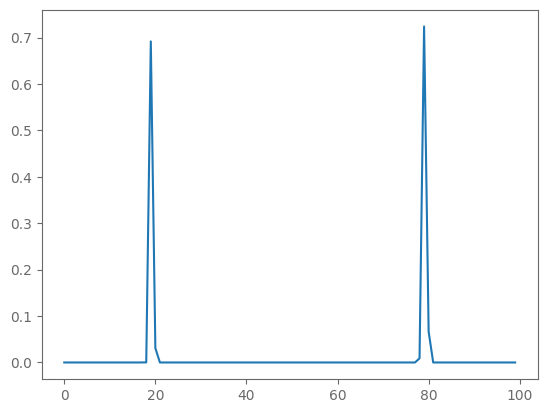

tensor([[0.6061, 0.7494, 0.9935,  ..., 0.8368, 0.5540, 0.6147],
        [0.8165, 0.9470, 0.3041,  ..., 0.6952, 0.3799, 0.0466],
        [0.6056, 0.3807, 0.1497,  ..., 0.5602, 0.3073, 0.7995],
        ...,
        [0.6056, 0.3807, 0.1497,  ..., 0.5602, 0.3073, 0.7995],
        [0.6061, 0.7494, 0.9935,  ..., 0.8368, 0.5540, 0.6147],
        [0.0936, 0.9531, 0.6390,  ..., 0.9060, 0.8542, 0.5956]])


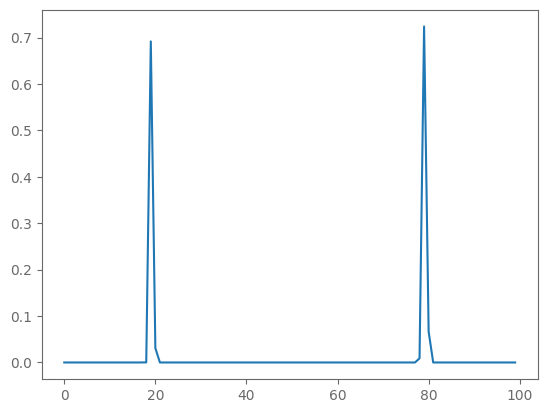

tensor([[0.9333, 0.3344, 0.3704,  ..., 0.9372, 0.1329, 0.0956],
        [0.0634, 0.6024, 0.4232,  ..., 0.5324, 0.2642, 0.5179],
        [0.3252, 0.9398, 0.4139,  ..., 0.4391, 0.1458, 0.3781],
        ...,
        [0.9346, 0.0364, 0.0351,  ..., 0.8222, 0.0265, 0.2303],
        [0.7471, 0.0469, 0.5326,  ..., 0.6940, 0.4824, 0.2279],
        [0.0634, 0.6024, 0.4232,  ..., 0.5324, 0.2642, 0.5179]])


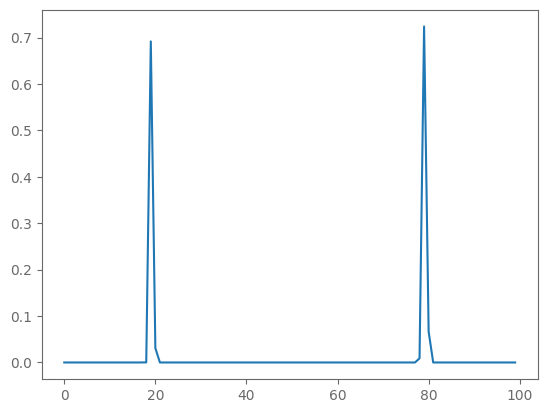

tensor([[0.4015, 0.1099, 0.4727,  ..., 0.1754, 0.1234, 0.1274],
        [0.8952, 0.7547, 0.6697,  ..., 0.0579, 0.7950, 0.5644],
        [0.1507, 0.9042, 0.7505,  ..., 0.4055, 0.7996, 0.1433],
        ...,
        [0.6061, 0.7494, 0.9935,  ..., 0.8368, 0.5540, 0.6147],
        [0.0687, 0.5576, 0.1516,  ..., 0.2871, 0.2653, 0.1059],
        [0.9333, 0.3344, 0.3704,  ..., 0.9372, 0.1329, 0.0956]])


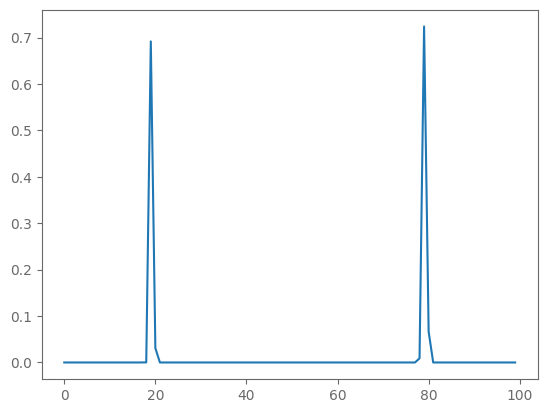

tensor([[0.0634, 0.6024, 0.4232,  ..., 0.5324, 0.2642, 0.5179],
        [0.9333, 0.3344, 0.3704,  ..., 0.9372, 0.1329, 0.0956],
        [0.5527, 0.2568, 0.9502,  ..., 0.6404, 0.6688, 0.4461],
        ...,
        [0.6061, 0.7494, 0.9935,  ..., 0.8368, 0.5540, 0.6147],
        [0.0233, 0.2187, 0.9720,  ..., 0.5107, 0.1689, 0.1564],
        [0.5687, 0.6024, 0.3838,  ..., 0.8165, 0.4853, 0.3338]])


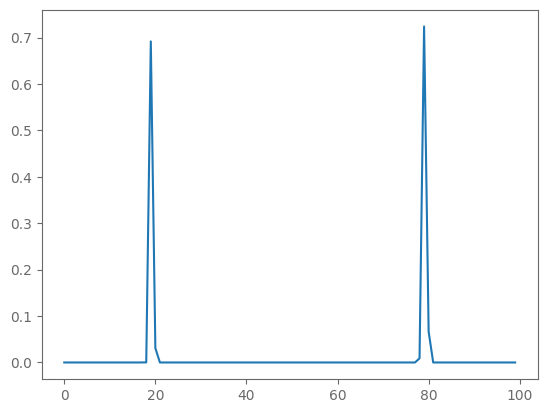

tensor([[0.2064, 0.8063, 0.9227, 0.1296, 0.5282, 0.5505, 0.5868, 0.8866, 0.8183,
         0.7933, 0.4404, 0.5264, 0.5113, 0.9786, 0.8800, 0.7747, 0.0915, 0.7038,
         0.7021, 0.1969, 0.6216, 0.3365, 0.0777, 0.3017, 0.2513, 0.3993, 0.4612,
         0.8730, 0.8794, 0.8578, 0.5532, 0.3637, 0.9639, 0.8869],
        [0.8398, 0.5155, 0.6170, 0.1470, 0.8983, 0.2996, 0.8590, 0.0587, 0.7325,
         0.1147, 0.0130, 0.7085, 0.5762, 0.2066, 0.4739, 0.3802, 0.6089, 0.4737,
         0.1794, 0.0532, 0.2764, 0.5728, 0.6941, 0.6855, 0.4358, 0.5565, 0.9840,
         0.4108, 0.3429, 0.3559, 0.9942, 0.0227, 0.0651, 0.6682],
        [0.8408, 0.8932, 0.4729, 0.8554, 0.1462, 0.9853, 0.2193, 0.8645, 0.6163,
         0.5127, 0.8656, 0.0306, 0.4500, 0.4999, 0.1511, 0.0092, 0.8257, 0.6663,
         0.8387, 0.1185, 0.6817, 0.2177, 0.9151, 0.3382, 0.3668, 0.1120, 0.2830,
         0.6601, 0.7089, 0.7943, 0.1813, 0.8150, 0.1427, 0.6258],
        [0.3877, 0.2713, 0.7861, 0.7595, 0.2623, 0.2569, 0.5472, 0.2836, 

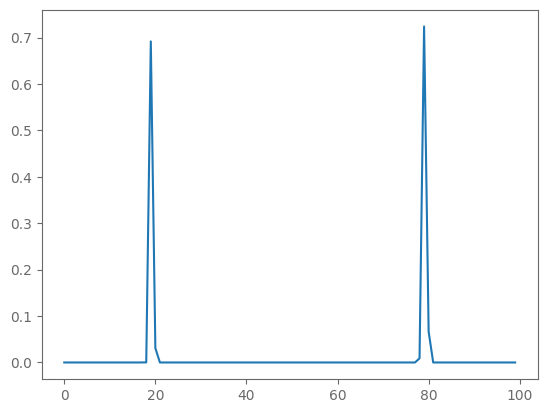

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import torch

for i in test_dl:
    plt.clf()
    print(i[0])
    plt.plot(model(torch.ones([1,34])*0.5)[0].detach().numpy())
    #plt.plot(i[1][0].flatten())
    plt.show()
    time.sleep(1)

In [4]:
# 1. load data & normalize
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from ray_tools.base.parameter import MutableParameter, NumericalParameter, RandomParameter, RayParameterContainer
from ray_optim.plot import Plot
param_container = params()
param_container = RayParameterContainer({label: NumericalParameter((entry.value_lims[1]-entry.value_lims[0]) / 2 + entry.value_lims[0]) if isinstance(entry, MutableParameter) else entry for label, entry in param_container.items()})
normalized_param_container = Plot.normalize_parameters(param_container, params())
print("test")

test


In [5]:
param_container

RayParameterContainer([('U41_318eV.numberRays', NumericalParameter: 100000.0),
                       ('U41_318eV.translationXerror',
                        NumericalParameter: 0.0),
                       ('U41_318eV.translationYerror',
                        NumericalParameter: 0.0),
                       ('U41_318eV.rotationXerror', NumericalParameter: 0.0),
                       ('U41_318eV.rotationYerror', NumericalParameter: 0.0),
                       ('ASBL.totalWidth', NumericalParameter: 2.0),
                       ('ASBL.totalHeight', NumericalParameter: 1.0),
                       ('ASBL.translationXerror', NumericalParameter: 0.0),
                       ('ASBL.translationYerror', NumericalParameter: 0.0),
                       ('M1_Cylinder.radius', NumericalParameter: 174.21),
                       ('M1_Cylinder.rotationXerror', NumericalParameter: 0.0),
                       ('M1_Cylinder.rotationYerror', NumericalParameter: 0.0),
                       ('M1_C

In [6]:
from ray_tools.base.engine import RayEngine
from ray_tools.base.backend import RayBackendDockerRAYUI
engine = RayEngine(rml_basefile='rml_src/METRIX_U41_G1_H1_318eV_PS_MLearn.rml',
                                exported_planes=["ImagePlane"],
                                ray_backend=RayBackendDockerRAYUI(docker_image='ray-ui-service',
                                                                  docker_container_name='ray-ui-service-test',
                                                                  dockerfile_path='ray_docker/rayui',
                                                                  ray_workdir='/dev/shm/ray-workdir',
                                                                  verbose=True),
                                num_workers=-1,
                                as_generator=False)

podman kill ray-ui-service-test
b'ray-ui-service-test\n'
podman rm ray-ui-service-test
b'ray-ui-service-test\n'
podman system prune -f
b'Total reclaimed space: 0B\n'
podman build --security-opt label=disable -f /home/dmeier/Schreibtisch/IES/research/metrix/metrix_hackathon/ray_docker/rayui/Dockerfile -t ray-ui-service
b'STEP 1/18: FROM stateoftheartio/qt6:6.4-gcc-aqt\nSTEP 2/18: USER root\n--> Using cache bdf43d50ef7260a467dc322bcc663426d1434fb0c6339a9d52e563e4745220be\n--> bdf43d50ef72\nSTEP 3/18: RUN sudo mkdir /usr/bin/gfortran\n--> Using cache 0d4e96de848c9935094508a30c35da0d0f8472678c809517048ea0c157d2eab6\n--> 0d4e96de848c\nSTEP 4/18: RUN apt update && apt -y install libglu1-mesa-dev freeglut3-dev mesa-common-dev wget git gfortran\n--> Using cache 6cf7b9282e8e4789fa508af02ef8449fd54f3bedc0af2ee30ead2abe4c5faa97\n--> 6cf7b9282e8e\nSTEP 5/18: RUN wget https://sourceforge.net/projects/qwt/files/qwt/6.2.0/qwt-6.2.0.tar.bz2/download\n--> Using cache be3c6bb52cc2315699dfec6652fb406273b

Sequential(
  (0): Linear(in_features=34, out_features=34, bias=True)
  (1): Mish()
  (2): Linear(in_features=34, out_features=77, bias=True)
  (3): Mish()
  (4): Linear(in_features=77, out_features=87, bias=True)
  (5): Mish()
  (6): Linear(in_features=87, out_features=100, bias=True)
  (7): Sigmoid()
)
podman exec ray-ui-service-test python3 /opt/script_rayui_bg.py /opt/ray-ui-workdir/l3u36nf9c4f5yrjw/workfile.rml -p "ImagePlane"
podman exec ray-ui-service-test python3 /opt/script_rayui_bg.py /opt/ray-ui-workdir/5h16etmpx2mqyksp/workfile.rml -p "ImagePlane"
b'load\nWarning: Importing an older rml-version, please check you parameters\ntrace\nsetAnalysis() entry: -9223337207282ms \nsetAnalysis() finished: -9223337207282ms \nexport\n'
b'load\nWarning: Importing an older rml-version, please check you parameters\ntrace\nsetAnalysis() entry: -9223337207162ms \nsetAnalysis() finished: -9223337207162ms \nexport\n'
Run ID l3u36nf9c4f5yrjw: Ray-UI output from workfile.rml successfully generate

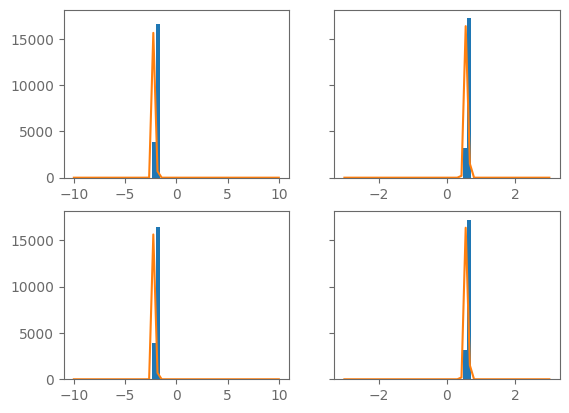

In [16]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from ray_nn.nn.xy_hist_data_models import HistSurrogateEngine
surrogate_engine = HistSurrogateEngine()


def plot_engines_comparison(engine, surrogate_engine, param_container_list):
    out = engine.run(param_container_list)
    out_surrogate = surrogate_engine.run(param_container_list)
    fig, ax = plt.subplots(len(param_container_list),2, sharey=True, squeeze=False)
    for i in range(len(out_surrogate)):
        surrogate_hist = out_surrogate[i]['ray_output']['ImagePlane']['xy_hist']
        ax[i, 0].hist(out[i]['ray_output']['ImagePlane'].x_loc, bins=50, histtype='bar', range=[-10, 10])
        ax[i, 0].plot(torch.linspace(-10, 10, 50), surrogate_hist.x_loc*22594.)
        ax[i, 1].hist(out[i]['ray_output']['ImagePlane'].y_loc, bins=50, histtype='bar', range=[-3, 3])
        ax[i, 1].plot(torch.linspace(-3, 3, 50), surrogate_hist.y_loc*22594.)
    plt.savefig('outputs/engines_comparison.png')

plot_engines_comparison(engine, surrogate_engine, [param_container for i in range(2)])

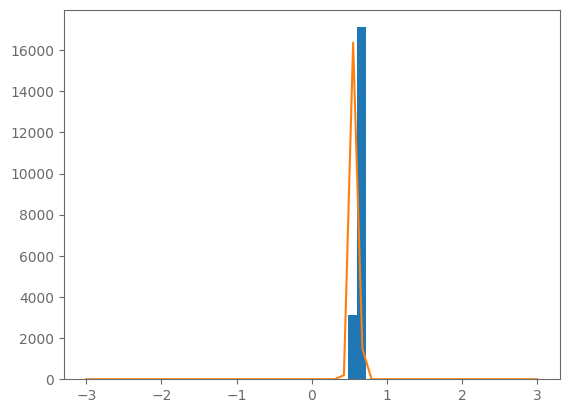